# Annotating Foreman-Mackey's `mixture-models` blog post

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

# This is by Dan Foreman-Mackey, 2014, slight modifications by dwc 20180125 for updated module to use corner.corner
# Original: DOI: 10.5281/zenodo.15856; <https://dfm.io/posts/mixture-models/>.

There are a lot of reasons why you might use a mixture model and there is a [huge](http://www.amazon.com/gp/product/1439840954?tag=danielfm-20) [related](http://www.amazon.com/gp/product/0387310738?tag=danielfm-20) [literature](http://arxiv.org/abs/1008.4686). That being said, there are a few questions that I regularly get so I thought that I would write up the answers.

In astronomy, the most common reason for using a mixture model is to fit data with outliers so that's the language I'll use but the results are applicable to any other mixture model. The questions that I'll try to answer are:

1. How do you derive the *marginalized* likelihood—as popularized by [Hogg *et al.* (2010)](http://arxiv.org/abs/1008.4686), I think—and why would you want to?
2. How do you work out the mixture membership probabilities (or what is the probability that the point is an outlier) after using this model?

## The basic model

The idea here is that you have some data drawn from the model that you care about and some data points that are outliers—drawn from a different model that you don't care about! For simplicity, let's consider a linear model. Everything that I derive here will be applicable to other more complicated models but it is easier to visualize the linear case. [Hogg *et al.* (2010)](http://arxiv.org/abs/1008.4686) give a nice treatment of this linear model with slightly different notation but they miss a few useful points in the discussion.

To start, let's generate some fake data:

In [38]:
import numpy as np
import matplotlib.pyplot as pl

# We'll choose the parameters of our synthetic data.
# The outlier probability will be 80%:
true_frac = 0.8

# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
x = np.sort(np.random.uniform(-2, 2, 15)) # makes 15 points
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x)) # 15 points

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
m_bkg = np.random.rand(len(x)) > true_frac #this is a Boolean array
y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1]+yerr[m_bkg]**2) * np.random.randn(sum(m_bkg))

Here's what these data look like. In this plot, the empty, square points are the true outliers. The purple line is the fit if we don't account for the fact that there are outliers and just treat all the points equally. Compare this to the correct answer (shown as the black line).

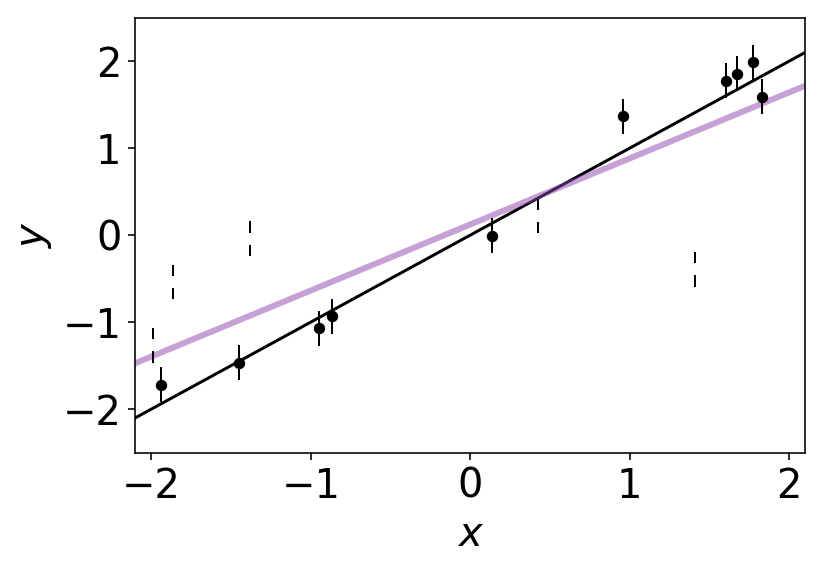

In [39]:
# First, fit the data and find the maximum likelihood model ignoring outliers.
# using the numpy.vander function to avoid writing a loop, so it is
# vectorized code:
A = np.vander(x, 2)
p = np.linalg.solve(np.dot(A.T, A / yerr[:, None]**2), np.dot(A.T, y / yerr**2))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)

# Plot the data and the truth.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
pl.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w", zorder=1000)
pl.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000)
pl.plot(x0, y0, color="k", lw=1.5)

# Plot the best fit line.
pl.plot(x0, x0 * p[0] + p[1], color="#8d44ad", lw=3, alpha=0.5)
# beware that due to the default order of vander, p[0] is slope, p[1] is intcp

pl.xlabel("$x$")
pl.ylabel("$y$")
pl.ylim(-2.5, 2.5)
pl.xlim(-2.1, 2.1);

The purple line is *clearly* a terrible fit because we ignored the outliers. To fix this, let's generalize this model and add a binary flag $q_k$ for each data point $k$. If $q_k$ is zero, then the point is "good" and the likelihood is given by the usual Gaussian:

$$p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k=0) = \frac{1}{\sqrt{2\,\pi\,\sigma_k^2}} \exp \left(-\frac{[y_k - f_\theta (x_k)]^2}{2\,\sigma_k^2}\right)$$

where $f_\theta (x_k) = \theta_1 \, x_k + \theta_2$ is the linear model.

Now, if $q_k = 1$ then the point is an outlier and the likelihood becomes:

$$p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k=1) = \frac{1}{\sqrt{2\,\pi\,[\sigma_k^2 + \theta_4]}} \exp \left(-\frac{[y_k - \theta_3]^2}{2\,[\sigma_k^2 + \theta_4]}\right) \quad.$$

I have made the simplifying assumption that the outliers are drawn from a single Gaussian with mean $\theta_3$ and variance $\theta_4$. From experience, the results aren't normally very sensitive to the choice of outlier model and the Gaussian model is often good enough but the following derivations will be valid for any model that you choose.

Under this new model, the full likelihood for the entire dataset becomes:

$$p(\{y_k\}\,|\,\{x_k\},\,\{\sigma_k\},\,\theta,\,\{q_k\}) = \prod_{k=1}^{K} p(y_k\,|\,x_k,\sigma_k,\,\theta,\,q_k)$$

where, for each term, the correct Gaussian is chosen depending on the value of $q_k$. To write this equation, I've assumed that the data points are independent and if that's not true for your dataset then things get *a lot* harder.

Now we could just take this likelihood function, apply priors, and use MCMC to find posterior constraints on $\theta$ and the $\{q_k\}$ flags but this would be hard for a few reasons. First, if you're used to using [emcee](http://dfm.io/emcee) for your MCMC needs, you'll find that it's pretty hard to implement a model with discrete variables so you'd probably need to learn some [other](http://pymc-devs.github.io/pymc/) [sampler](http://mc-stan.org/) and, honestly, it probably wouldn't work well for this problem either! Which brings us to our second problem. This problem is *very* high dimensional and the dimension scales with the number of data points. Without the outlier model, the problem is only two-dimensional but when we include the outliers, the model suddenly becomes $(4 + K)$-dimensional, where $K$ is the number of data points. This will always be hard! Therefore, in practice, it is useful to marginalize out the badly behaved parameters ($q_k$) and just sample in $\theta$.

## The marginalized likelihood

In order to marginalize out the $\{q_k\}$ flags, we need to choose a prior $p(q_k)$. After making this choice (I won't specialize yet), the marginalization can be written:

$$p(\{y_k\}\,|\,\{x_k\},\,\{\sigma_k\},\,\theta) = \sum_{\{q_k\}} \prod_{k=1}^{K} p(q_k) \, p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k)$$

where the sum is over all the possible permutations of the $q_k$ flags. If you squint for a second, you'll see that you can actually switch the order of the sum and product without changing anything. This follows from our assumption that the data points are independent. Therefore, we're left with the much simpler likelihood function

$$p(\{y_k\}\,|\,\{x_k\},\,\{\sigma_k\},\,\theta) = \prod_{k=1}^{K} p(y_k\,|\,x_k,\,\sigma_k,\,\theta)$$

where

$$p(y_k\,|\,x_k,\,\sigma_k,\,\theta) = \sum_{q_k} p(q_k) \, p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k) \quad.$$

The prior $p(q_k)$ could be different for every data point but it is often sufficient to choose a simple model like

$$p(q_k) = \left \{\begin{array}{ll}
Q & \mathrm{if}\,q_k=0 \\
1-Q & \mathrm{if}\,q_k=1
\end{array}\right.$$

where $Q \in [0, 1]$ is a constant that sets the prior probability that a point is drawn from the foreground model. Chosing this model, we recover the (possibly) familiar likelihood function from [Hogg *et al.* (2010)](http://arxiv.org/abs/1008.4686):

$$p(\{y_k\}\,|\,\{x_k\},\,\{\sigma_k\},\,\theta) = \prod_{k=1}^{K} \left [ Q\,p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k=0) + (1-Q)\,p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k=1) \right ] \quad.$$

This is a much easier model to sample so let's do that now:

In [40]:
import emcee

# Define the probabilistic model...
# A simple prior:
bounds = [(0.1, 1.9), (-0.9, 0.9), (0, 1), (-2.4, 2.4), (-7.2, 5.2)]
def lnprior(p):
    # We'll just put reasonable uniform priors on all the parameters.
    if not all(b[0] < v < b[1] for v, b in zip(p, bounds)):
        return -np.inf
    return 0

# The "foreground" linear likelihood:
def lnlike_fg(p):
    """log likelihood of fg for every data point"""
    m, b, _, M, lnV = p
    model = m * x + b
    return -0.5 * (((model - y) / yerr) ** 2 + 2 * np.log(yerr))
    # returns 15 points due to globals x, y, yerr

# The "background" outlier likelihood:
def lnlike_bg(p):
    """log likelihood of bg for every data point"""
    _, _, Q, M, lnV = p
    var = np.exp(lnV) + yerr**2
    return -0.5 * ((M - y) ** 2 / var + np.log(var))
    # returns 15 pts due to global y

# Full probabilistic model.
def lnprob(p):
    m, b, Q, M, lnV = p
    
    # First check the prior.
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf, None #dwc: note the None is for consistency below
    
    # Compute the vector of foreground likelihoods and include the q prior.
    ll_fg = lnlike_fg(p)
    arg1 = ll_fg + np.log(Q)
    #this will save ll_fg times foreground prob FOR EVERY DATA POINT
    # so whatever Q we walk off to for each point is kept!
    
    # Compute the vector of background likelihoods and include the q prior.
    ll_bg = lnlike_bg(p)
    arg2 = ll_bg + np.log(1.0 - Q)
    #this will save ll_fg times background prob FOR EVERY DATA POINT
    
    # Combine these using log-add-exp for numerical stability.
    ll = np.sum(np.logaddexp(arg1, arg2))
    
    # We're using emcee's "blobs" feature in order to keep track of the
    # foreground and background likelihoods for reasons that will become
    # clear soon.
    return lp + ll, (arg1, arg2)
    # lp + ll will be posteriors for each point (?)
    # extra args keep foreground and background probs for every data point 
    # for every parameter set in walker chains as arg1, arg2

# Initialize the walkers at a reasonable location.
ndim, nwalkers = 5, 32
p0 = np.array([1.0, 0.0, 0.7, 0.0, np.log(2.0)])
p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]
# this turns p0 into a list of arrays that is nwalkers long (list comprehension)

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Run a burn-in chain and save the final location.
# p0 is the list of initial parameters for every walker.
pos, _, _, _ = sampler.run_mcmc(p0, 500)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(pos, 1500);

This code should only take about a minute to run. Compare that to any attempt you've ever made at sampling the same problem with another 15 or more parameters and you should be pretty stoked!

Let's show the resulting parameter constraints and compare them to the *true* values (indicated in blue) used to generate the synthetic dataset. This should encourage us that we've done something reasonable.

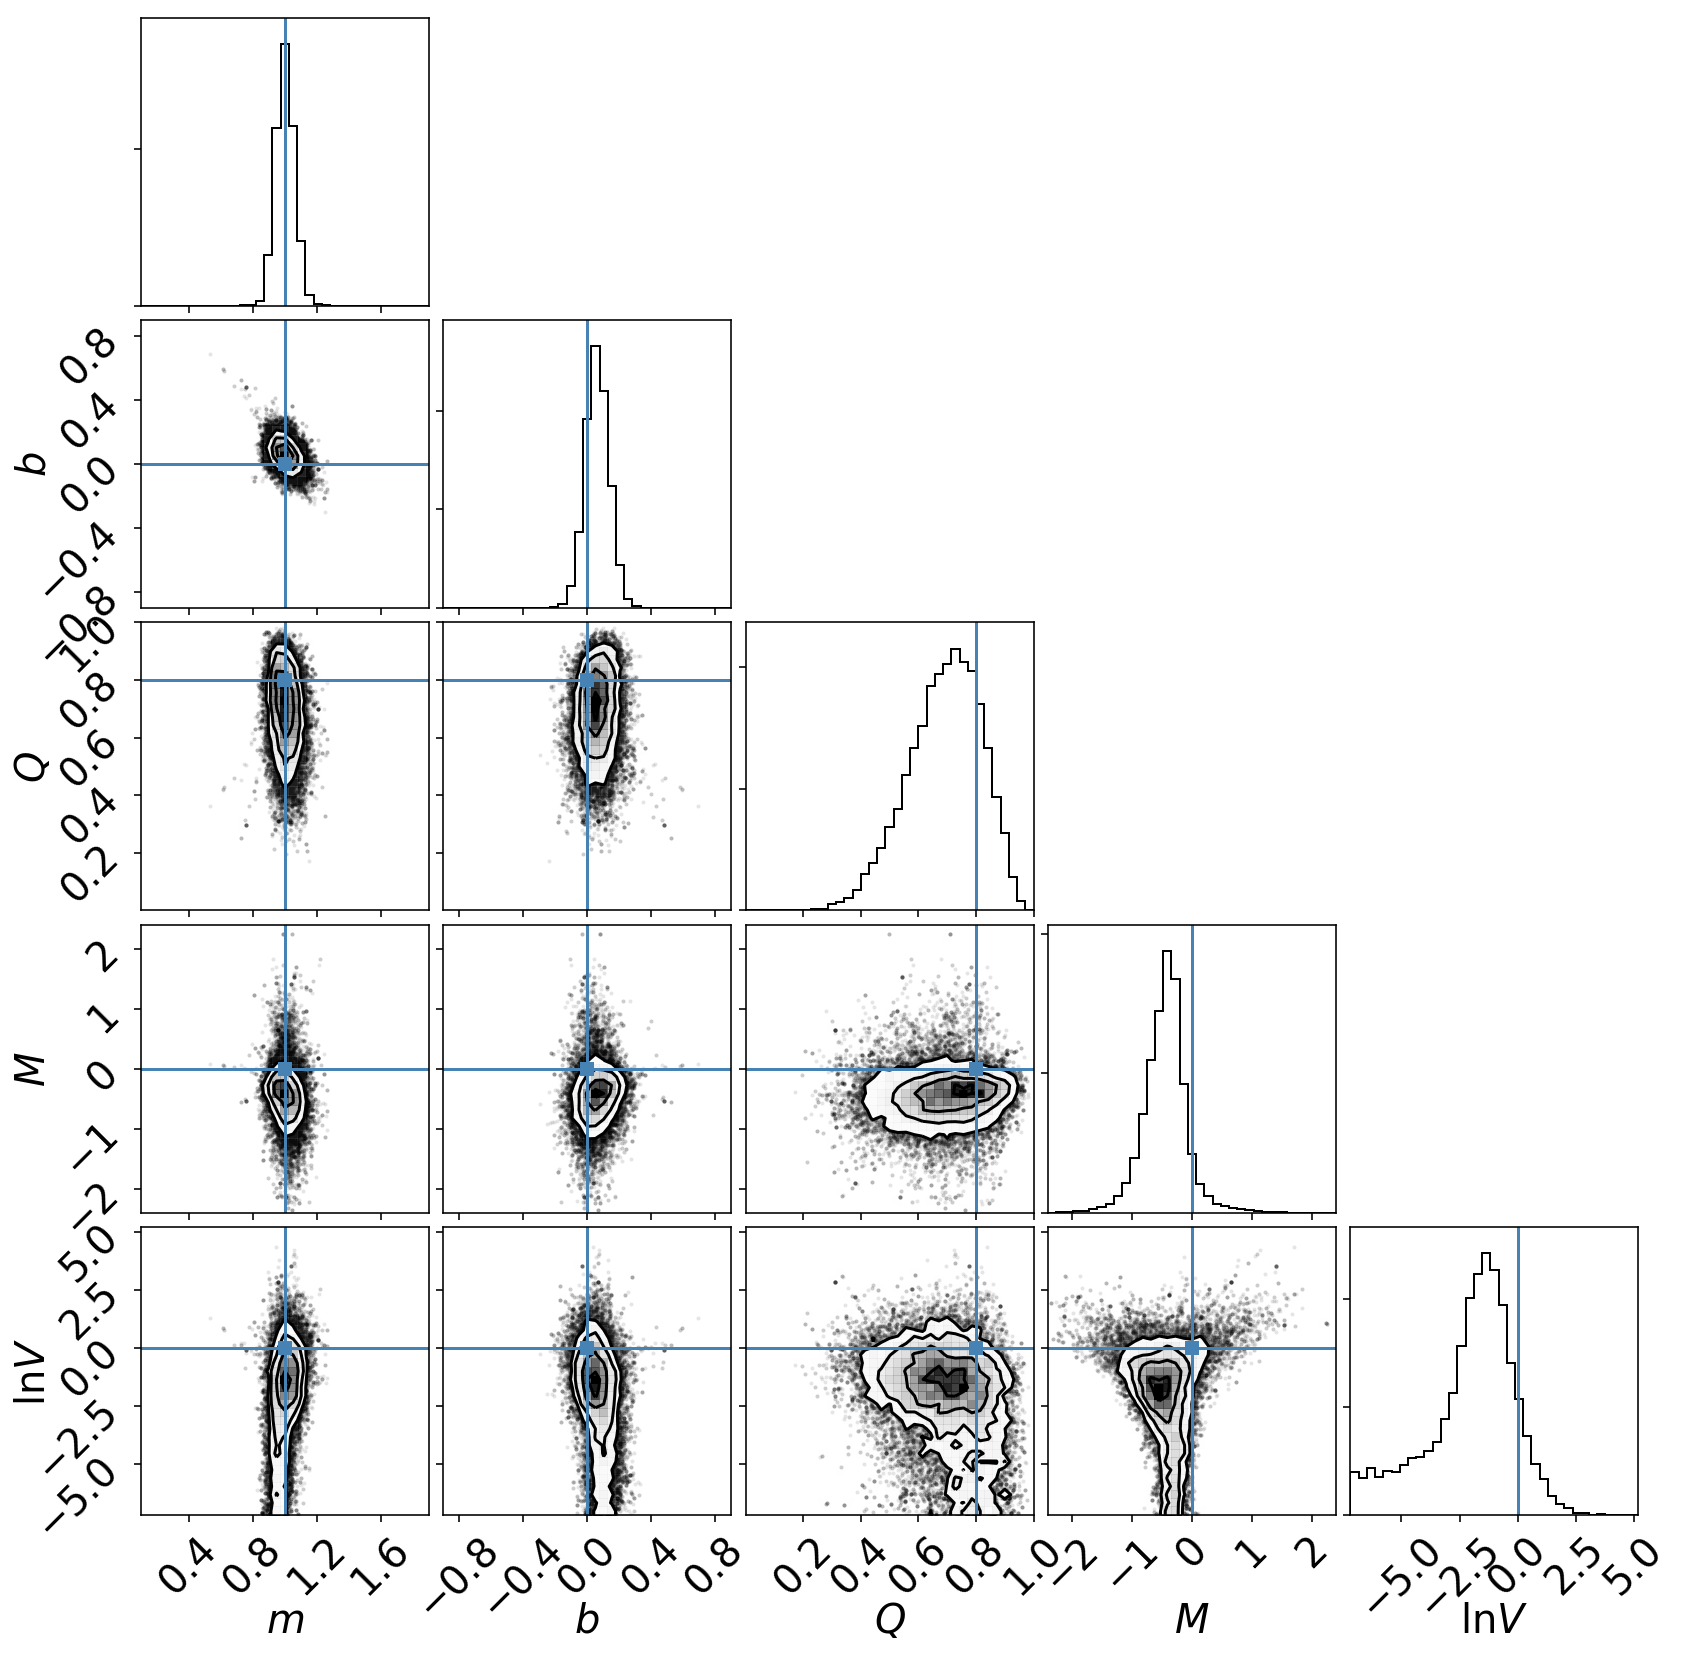

In [41]:
import corner  #note by dwc: changed triangle to corner. name conflict: output of ??triangle indicates that it is 
                # a voronoi geometry package or similar.
labels = ["$m$", "$b$", "$Q$", "$M$", "$\ln V$"]
truths = true_params + [true_frac, true_outliers[0], np.log(true_outliers[1])]
corner.corner(sampler.flatchain, bins=35, range=bounds, labels=labels, truths=truths);
# also changed extents to range in kwargs, based on deprecation warning.

Similarly, the predicted constraint on the linear model is:

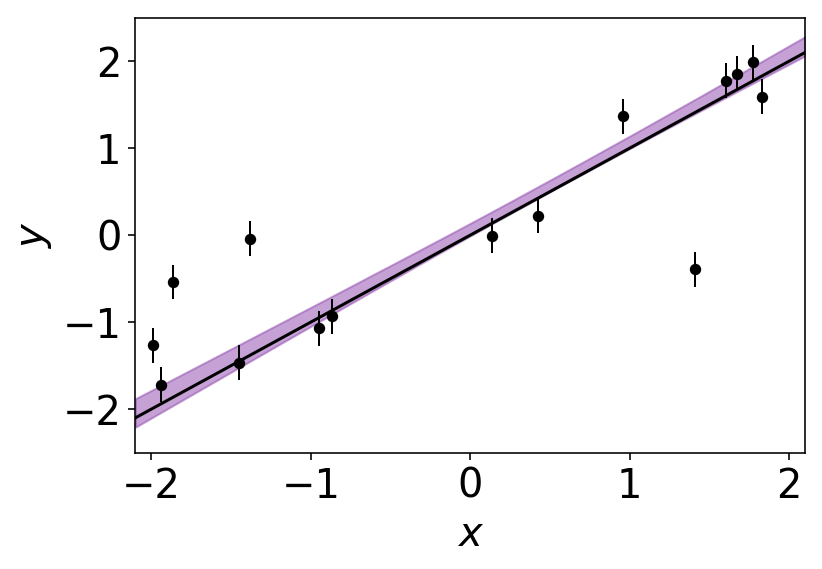

In [42]:
# Compute the quantiles of the predicted line and plot them.
A = np.vander(x0, 2)
lines = np.dot(sampler.flatchain[:, :2], A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
pl.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5)

# Plot the data.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
pl.scatter(x, y, marker="o", s=22, c="k", zorder=1000)

# Plot the true line.
pl.plot(x0, y0, color="k", lw=1.5)

pl.xlabel("$x$")
pl.ylabel("$y$")
pl.ylim(-2.5, 2.5)
pl.xlim(-2.1, 2.1);

Great! Comparing the purple swath to the true line (shown in black), I think that we can all agree that this is a much better fit! But now, how do we label the points to decide which ones are outliers?

## Mixture membership probabilities

Okay. So now we have a model that we can sample and it seems to give us reasonable results but didn't we throw away a lot of information when we used the marginalized likelihood instead of sampling in the $q_k$ parameters? If we sampled the full model, we would, after all, get marginalized posterior constraints on the *outlierness* of each point. This is a very common question when I suggest that people use this model so I wanted to show that you're actually not throwing anything away and with a tiny bit of extra computation, you can recover these constraints!

To be specific, the thing that we want to compute is:

$$p(q_k\,|\,y) = \int p(q_k,\,\theta\,|\,y)\,\mathrm{d}\theta = \int p(q_k\,|\,y,\,\theta)\,p(\theta\,|\,y)\,\mathrm{d}\theta \quad,$$

the posterior probability of a specific point $k$ being good ($q_k=0$) given all the data. In this equation, I've simplified the notation a bit and $y = \{y_k\}$ now indicates *all the data* and I'm leaving out the implied $\{x_k\},\,\{\sigma_k\}$ on the right-hand side of every probability. To compute this, we'll need to evaluate the conditional probability

$$p(q_k\,|\,y,\,\theta) = \frac{p(q_k)\,p(y\,|\,\theta,\,q_k)}{\sum_{j} p(q_k=j)\,p(y\,|\,\theta,\,q_k=j)}$$

where the sum is over every allowed value of $q_k$. Both the numerator and denominator are used when computing the marginalized likelihood so if we hang onto those, we can re-use them to compute the membership probabilities. In the example above, I stored these results using emcee's [blobs feature](http://dan.iel.fm/emcee/current/user/advanced/#arbitrary-metadata-blobs) so it'll be ease to evaluate $p(q_k\,|\,y,\,\theta^{(n)})$ for each sample $\theta^{(n)}$ from the chain.

Then, we need to realize that the Markov chain gave us samples $\theta^{(n)}$ from the probability distribution $p(\theta\,|\,y)$, so we can approximate the previous integral as

$$p(q_k\,|\,y) = \int p(q_k\,|\,y,\,\theta)\,p(\theta\,|\,y)\,\mathrm{d}\theta \approx \frac{1}{N}\sum_{n=1}^N p(q_k\,|\,y,\,\theta^{(n)}) \quad.$$

Therefore, the posterior probaility of being an outlier or not can be computed by just taking the average of a bunch of values that we've already computed! In practice, this would look like the following:

In [43]:
norm = 0.0
post_prob = np.zeros(len(x))
for i in range(sampler.chain.shape[1]):     # i is length of each walker's chain
    for j in range(sampler.chain.shape[0]): # j is number of walkers
        ll_fg, ll_bg = sampler.blobs[i][j]  # each of these includes each data point
        post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg)) # (fg lklhd)/(total lklhd)
        norm += 1   #however many times
post_prob /= norm

Therefore, from left to right, the marginalized posterior probability that each point is part of the foreground model is:

In [44]:
print(", ".join(map("{0:.3f}".format, post_prob)))

0.355, 0.939, 0.000, 0.956, 0.000, 0.895, 0.889, 0.835, 0.861, 0.967, 0.000, 0.994, 0.995, 0.995, 0.975


This model works pretty well... so well, in fact, that the strong outliers are given nearly zero probability of being in the foreground model!

Finally, it can be useful to label outliers on the final plot so let's use a color scale on the points to show this probability. In the figure below, darker points are more likely to be drawn from the line. This plot is pretty satisfying because the model has done a good job labeling all but one outlier at high confidence!

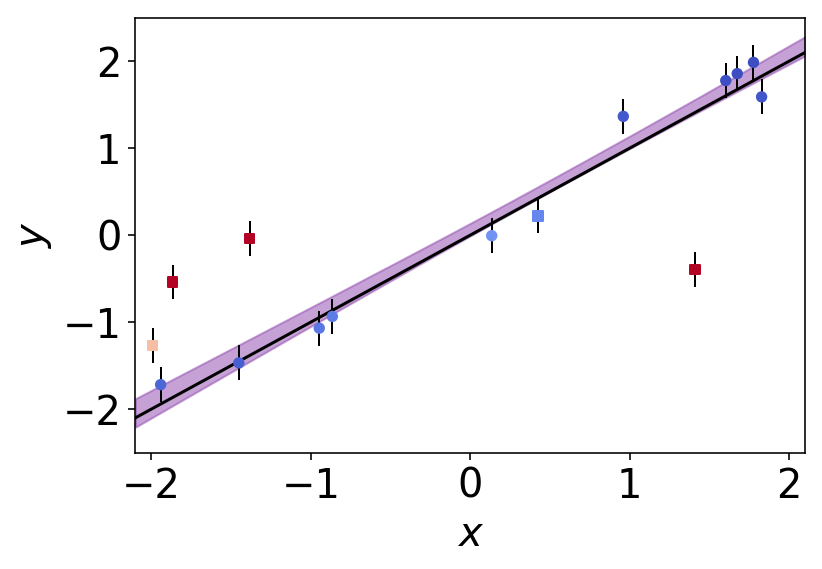

In [45]:
# Plot the prediction.
pl.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5)

# Plot the data points.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
# Plot the (true) outliers.
pl.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c=post_prob[m_bkg], cmap="coolwarm_r", vmin=0, vmax=1, zorder=1000)
# Plot the (true) good points.
pl.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c=post_prob[~m_bkg], cmap="coolwarm_r", vmin=0, vmax=1, zorder=1000)

# Plot the true line.
pl.plot(x0, y0, color="k", lw=1.5)

pl.xlabel("$x$")
pl.ylabel("$y$")
pl.ylim(-2.5, 2.5)
pl.xlim(-2.1, 2.1);

**Acknowledgments** &nbsp;
*I'd like to thank [Ruth Angus](http://ruthang.us) for useful comments.*

In [46]:
sampler.chain.shape

(32, 1500, 5)

In [11]:
sampler.blobs[1400][16] #take a look at one of the blob chain values.

(array([-5.66228832e+00,  3.79309953e-01, -2.13382058e+01,  1.05112640e+00,
        -2.23829287e+01,  9.65757157e-01,  1.04188270e+00,  9.93487151e-01,
         8.61687387e-01, -2.12183391e+00, -3.46729932e+01, -2.09070352e-02,
        -9.32608932e-02, -3.36246611e-01,  8.93001624e-01]),
 array([-1.08112079e+00, -3.23451993e+00, -1.88399384e-02, -1.90496516e+00,
        -9.93310264e-01, -5.04384196e-01, -2.32930336e-01, -1.10974459e+00,
        -2.04756961e+00, -1.12032753e+01, -1.61609070e-01, -1.62815510e+01,
        -1.73723771e+01, -1.92196929e+01, -1.38507481e+01]))

array([ -4.97587713,   0.98590654, -20.41677499,   1.60574946,
       -20.94822009,   1.42253145,   1.54836783,   1.36063013,
         1.0836175 ,  -0.4455494 , -39.0216144 ,   1.22824112,
         1.19485732,   1.06063745,   0.9018412 ])